#### 필요한 라이브러리 불러오기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

#### 필요한 변수들 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 64
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


#### 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


#### train:val 80:20 나눠주기

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


#### 페렴 이미지와 정상 이미지 세어보기

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


#### mini-batch로 작업할수있게 바꿔주기

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

#### train 데이터셋, validation 데이터셋 개수 확인

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

#### train 데이터 셋과 validation 데이터 셋을 만들기

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

#### 이미지가 잘 resize 되었는지 라벨이 잘 들어갔는지 확인

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


#### 테스트 데이터 만들기(개수 확인)

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

#### 데이터 시각화

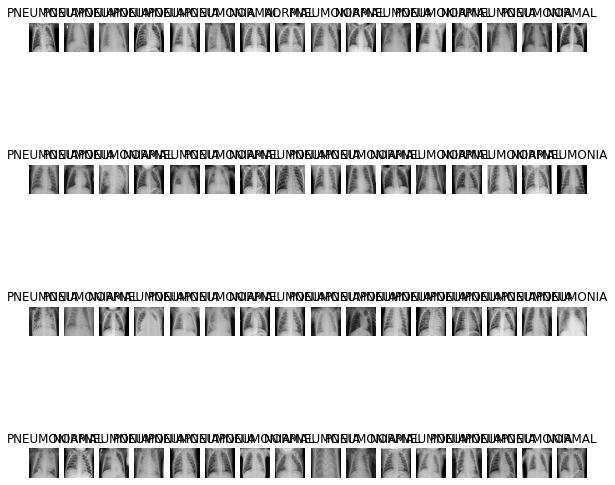

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

#### CNN을 modeling 해주고 결과를 만드는 작업 

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#### 데이터 imbalace 처리 하기

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


#### 모델 훈련하기

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

#### 케라스에서 best-model.h5 불러오기

In [21]:
#from tensorflow import keras
#with tf.device('/GPU:0'):
    
 #   cb = keras.callbacks.ModelCheckpoint('best-model.h5')
  #  es = keras.callbacks.EarlyStopping(
   #     patience=3,
    #    restore_best_weights=True)
    
    
    #history = model.fit(
     #   train_ds,
      #  steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
       # epochs=EPOCHS,
        #validation_data=val_ds,
        #validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        #class_weight=class_weight,
        #callbacks = [cb, es]
    #)    

#### 모델을 fit 시켜주기

In [22]:
from tensorflow import keras
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
       
    )

Epoch 1/25
65/65 [==============================] - 61s 728ms/step - loss: 0.4804 - accuracy: 0.7481 - precision: 0.9503 - recall: 0.6980 - val_loss: 0.6002 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 2/25
65/65 [==============================] - 48s 741ms/step - loss: 0.2631 - accuracy: 0.8983 - precision: 0.9758 - recall: 0.8853 - val_loss: 0.6549 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 3/25
65/65 [==============================] - 49s 758ms/step - loss: 0.1825 - accuracy: 0.9317 - precision: 0.9801 - recall: 0.9268 - val_loss: 0.7811 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 4/25
65/65 [==============================] - 51s 788ms/step - loss: 0.1512 - accuracy: 0.9397 - precision: 0.9808 - recall: 0.9374 - val_loss: 0.9325 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/25
65/65 [==============================] - 44s 689ms/step - loss: 0.1180 - accuracy: 0.9553

#### 훈련결과를 그래프로 확인하기

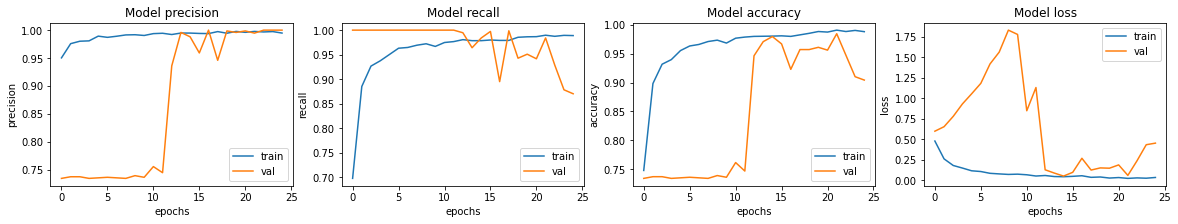

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
#best_model =keras.models.load_model('best-model.h5')

#### 모델 평가 결과확인

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 5s 455ms/step - loss: 0.5230 - accuracy: 0.8718 - precision: 0.8875 - recall: 0.9103
Loss: 0.5230098962783813,
Accuracy: 0.8717948794364929,
Precision: 0.887499988079071,
Recall: 0.9102563858032227


### 프로잭트 회고

##### 루브릭 기준인 정확도 85를 계속 넘기지 못함

##### 계속 정확도를 넘기지 못해  구글링을 하다 보니 케글에서 best-model을 불러오면  결과값이 잘나온다는걸 알게됨  

##### best-model을 사용해 봤더니 오히려 처음보다 정확도가 더 낮게 나옴

##### 이번에는 batch_size 32 , 64로 epoch 30 으로 늘려 보았더니 정확도가  루브릭 평가 기준을 넘김

##### nlp 노드에서 루브릭 평가 기준 정확도를 넘긴게 이번에 처음이라서 뿌듯하다!!